In [1]:
import os
os.environ['SETIGEN_ENABLE_GPU'] = '1'
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from astropy import units as u
import blimpy as bl

import sys
sys.path.insert(0, "/mnt_home/bryanb/setigen/")
import setigen as stg

bshuf filter already loaded, skip it.
lz4 filter already loaded, skip it.
zfp filter already loaded, skip it.


In [2]:
%matplotlib inline

Blocks: 100%|██████████| 1/1 [00:09<00:00,  9.46s/it]     

working stem: example_1block
opening file: example_1block.0000.raw


opening file: example_1block.0001.raw [No such file or directory]
output product 0: 128 spectra


Blocks: 100%|██████████| 1/1 [00:14<00:00, 14.20s/it]     

working stem: example_1block_input
opening file: example_1block_input.0000.raw


opening file: example_1block_input.0001.raw [No such file or directory]
output product 0: 128 spectra


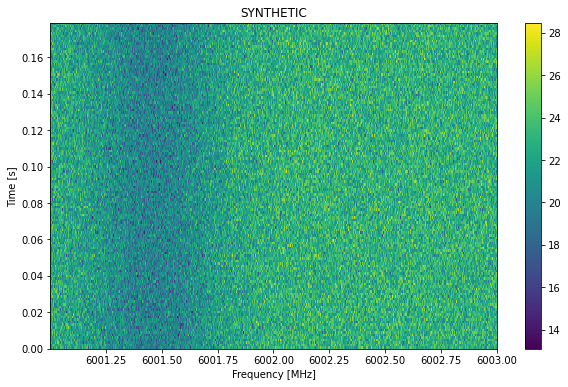

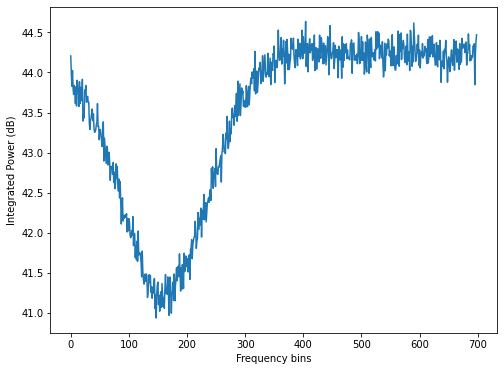

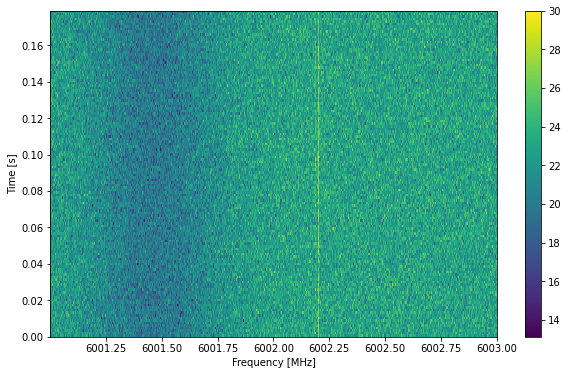

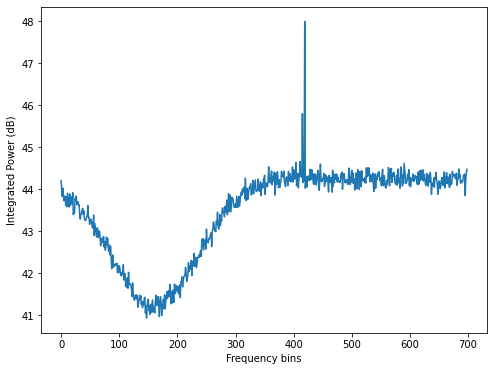

In [11]:
sample_rate = 3e9
num_taps = 8
num_branches = 1024

chan_bw = sample_rate / num_branches

antenna = stg.voltage.Antenna(sample_rate=sample_rate, 
                              fch1=6*u.GHz,
                              ascending=True,
                              num_pols=2)

for stream in antenna.streams:
    stream.add_noise(0, 1)
#     stream.add_constant_signal(f_start=6002.2e6, 
#                                drift_rate=-2,
#                                level=0.002,
#                                phase=0)
    
digitizer = stg.voltage.RealQuantizer(target_mean=0, 
                                      target_fwhm=32,
                                      num_bits=8)

filterbank = stg.voltage.PolyphaseFilterbank(num_taps=num_taps, 
                                             num_branches=num_branches)

requantizer = stg.voltage.ComplexQuantizer(target_mean=0,
                                           target_fwhm=32,
                                           num_bits=8)

rvb = stg.voltage.RawVoltageBackend(antenna,
                                    digitizer=digitizer,
                                    filterbank=filterbank,
                                    requantizer=requantizer,
                                    start_chan=0,
                                    num_chans=64,
                                    block_size=134217728,
                                    blocks_per_file=128,
                                    num_subblocks=32)

rvb.record(output_file_stem='example_1block',
           num_blocks=1, 
           length_mode='num_blocks',
           header_dict={'HELLO': 'test_value',
                        'TELESCOP': 'GBT'},
           verbose=False)

!rawspec -f 1024 -t 4 example_1block

#####################################
sample_rate = 3e9
num_taps = 8
num_branches = 1024

input_file_stem = 'example_1block'

start_chan = 0

# currently this is 'populate_pipeline_elements' in read_raw.ipynb
raw_params = stg.voltage.get_raw_params(input_file_stem=input_file_stem,
                                        start_chan=start_chan)
# sample_rate and delays aren't actually used by the raw file... this is just for convenience


# antenna = stg.voltage.Antenna(sample_rate=raw_params['sample_rate'], 
#                               fch1=raw_params['fch1'],
#                               ascending=raw_params['ascending'],
#                               num_pols=raw_params['num_pols'])

"""or"""
# accept dict, create antenna automatically! just expand dict; added kwargs to antennas 
# to accept these parameters!
antenna = stg.voltage.Antenna(sample_rate=sample_rate,
                              **raw_params)

for stream in antenna.streams:
#     stream.add_noise(0, 1)
    stream.add_constant_signal(f_start=6002.2e6, 
                               drift_rate=-2,
                               level=0.002*2**0.5,
                               phase=0)

# maa = stg.voltage.MultiAntennaArray(sample_rate, 
#                                     **raw_params, 
#                                     delays=None)
    
digitizer = stg.voltage.RealQuantizer(target_mean=0, 
                                      target_fwhm=32,
                                      num_bits=8)

filterbank = stg.voltage.PolyphaseFilterbank(num_taps=num_taps, 
                                             num_branches=num_branches)

rvb = stg.voltage.RawVoltageBackend.from_data(input_file_stem=input_file_stem,
                                              antenna_source=antenna,
                                              digitizer=digitizer,
                                              filterbank=filterbank,
                                              start_chan=start_chan,
                                              num_subblocks=32)

rvb.record(output_file_stem='example_1block_input',
           num_blocks=1, 
           length_mode='num_blocks',
           header_dict={'HELLO': 'test_value',
                        'TELESCOP': 'GBT'},
           digitize=False,
           verbose=False)

# get_dists('example_1block_input.0000.raw')
!rawspec -f 1024 -t 4 example_1block_input

wf = bl.Waterfall('example_1block.rawspec.0000.fil',
                  f_start=6001.0,
                  f_stop=6003)

plt.figure(figsize=(10, 6))
wf.plot_waterfall()
plt.show()

x = stg.db(np.sum(wf.data[:, 0, :], axis=0))

plt.figure(figsize=(8, 6))
plt.plot(x)
plt.xlabel('Frequency bins')
plt.ylabel('Integrated Power (dB)')
plt.show()

wf = bl.Waterfall('example_1block_input.rawspec.0000.fil',
                  f_start=6001.0,
                  f_stop=6003)

plt.figure(figsize=(10, 6))
wf.plot_waterfall()
plt.show()

x = stg.db(np.sum(wf.data[:, 0, :], axis=0))

plt.figure(figsize=(8, 6))
plt.plot(x)
plt.xlabel('Frequency bins')
plt.ylabel('Integrated Power (dB)')
plt.show()

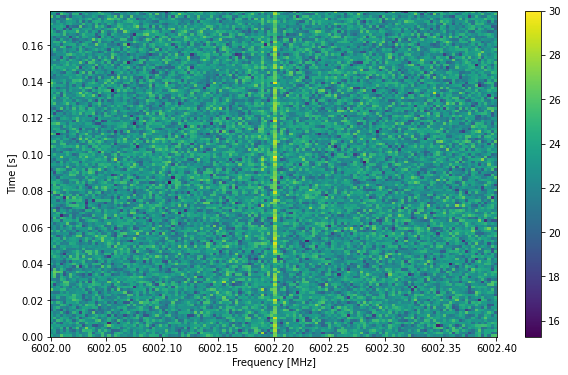

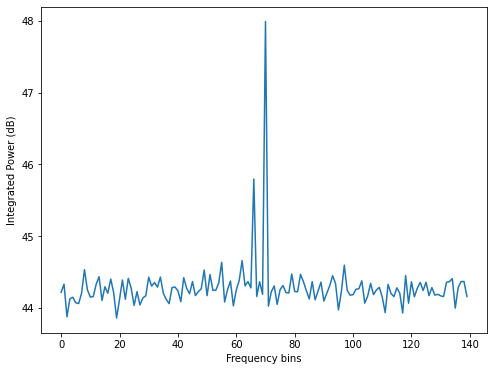

In [12]:
wf = bl.Waterfall('example_1block_input.rawspec.0000.fil',
                  f_start=6002.0,
                  f_stop=6002.4)

plt.figure(figsize=(10, 6))
wf.plot_waterfall()
plt.show()

x = stg.db(np.sum(wf.data[:, 0, :], axis=0))

plt.figure(figsize=(8, 6))
plt.plot(x)
plt.xlabel('Frequency bins')
plt.ylabel('Integrated Power (dB)')
plt.show()

In [13]:
ls

03_fine_channelization.ipynb           look_at_rawspec.ipynb
4bit_calculations.ipynb                rawspec/
coarse_chan_edges.ipynb                raw_voltage_files.ipynb
deconstructed_pipeline.ipynb           raw_voltage_pipeline.ipynb
example_1block.0000.raw                read_raw.ipynb
example_1block_input.0000.raw          reduce_all.sh*
example_1block_input.rawspec.0000.fil  setigen_voltage_dev.ipynb
example_1block.rawspec.0000.fil        Sim time series.ipynb
example_snr.0000.raw                   test_0.0000.raw
example_snr.rawspec.0000.fil           test.0000.raw
fft_tests.py                           test_0.rawspec.0000.fil
gen_alias.py                           test_4bit.0000.raw
gen_array_raw.py                       test_4bit.rawspec.0000.fil
gen_full5min.py                        test_alias.0000.raw
gen_full5min_snr.py                    test_alias.rawspec.0000.fil
gen_lower_sampling.py                  test.fil
gen_raw.py                             test_multiantenna.00

Subblocks:   0%|          | 0/1 [00:00<?, ?it/s]

0.0004973194289112802 1.0002579807669087
before requant
0.0013009317034927991 0.6773329237983463
-0.001550206689725625 0.662330640007423



Blocks: 100%|██████████| 1/1 [00:01<00:00,  1.06s/it]   

working stem: example_small
opening file: example_small.0000.raw


opening file: example_small.0001.raw [No such file or directory]
output product 0: 80 spectra


Blocks: 100%|██████████| 1/1 [00:00<00:00,  3.54it/s]   

2.922067068251734e-05 0.3535563063276553
before requant
-0.0006079186979437935 0.7103416083251759
-0.00022306513948946362 0.7098087681940984
-------
13.590188927560892 13.592151485070456
-0.013818359375 12.741886376355126
-0.00712890625 12.747732563354969
working stem: example_small_input
opening file: example_small_input.0000.raw


opening file: example_small_input.0001.raw [No such file or directory]
output product 0: 80 spectra


/datax/scratch/bbrzycki/miniconda3/envs/bl_tf/lib/python3.8/site-packages/blimpy/utils.py:10: RuntimeWarning: divide by zero encountered in log10
  return 10 * np.log10(x + offset)


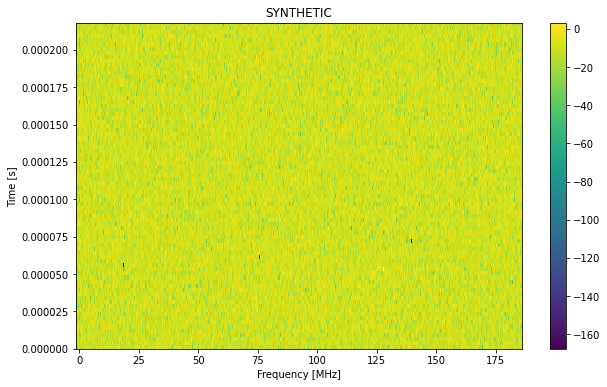

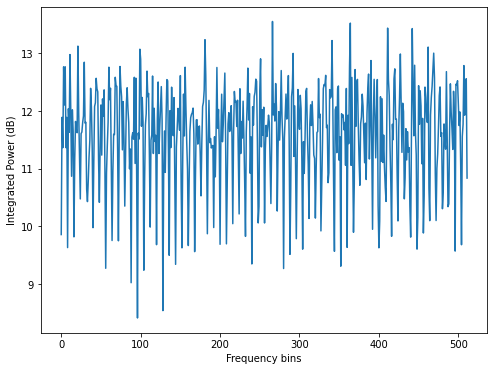

/datax/scratch/bbrzycki/miniconda3/envs/bl_tf/lib/python3.8/site-packages/blimpy/utils.py:10: RuntimeWarning: divide by zero encountered in log10
  return 10 * np.log10(x + offset)


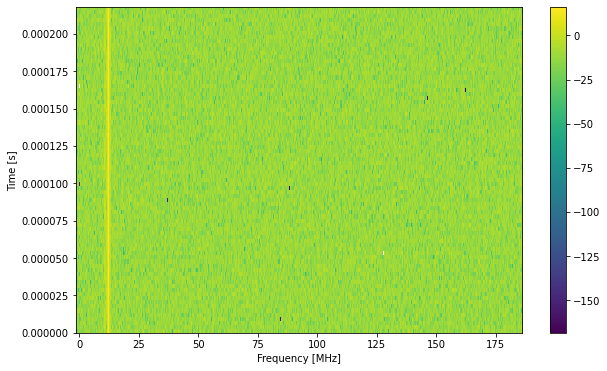

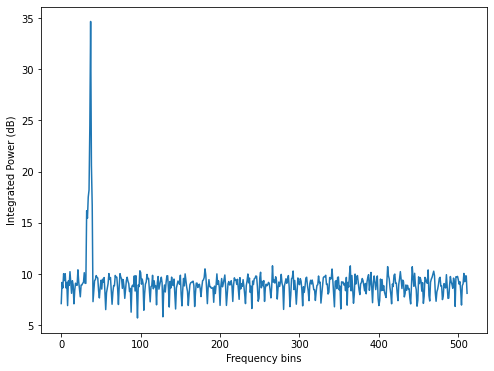

In [3]:
sample_rate = 3e9
num_taps = 8
num_branches = 1024

chan_bw = sample_rate / num_branches

antenna = stg.voltage.Antenna(sample_rate=sample_rate, 
                              fch1=0,
                              ascending=True,
                              num_pols=1)

for stream in antenna.streams:
    stream.add_noise(0, 1)
#     stream.add_constant_signal(f_start=12e6, 
#                                drift_rate=-2,
#                                level=0.5,
#                                phase=0)
    
digitizer = stg.voltage.RealQuantizer(target_mean=0, 
                                      target_fwhm=32,
                                      num_bits=8)

filterbank = stg.voltage.PolyphaseFilterbank(num_taps=num_taps, 
                                             num_branches=num_branches)

requantizer = stg.voltage.ComplexQuantizer(target_mean=0,
                                           target_fwhm=32,
                                           num_bits=8)

rvb = stg.voltage.RawVoltageBackend(antenna,
                                    digitizer=digitizer,
                                    filterbank=filterbank,
                                    requantizer=requantizer,
                                    start_chan=0,
                                    num_chans=64,
                                    block_size=8*1024*10,
                                    blocks_per_file=128,
                                    num_subblocks=1)

rvb.record(output_file_stem='example_small',
           num_blocks=1, 
           length_mode='num_blocks',
           header_dict={'HELLO': 'test_value',
                        'TELESCOP': 'GBT'},
           digitize=False,
           verbose=False)

!rawspec -f 8 -t 1 example_small

#####################################
sample_rate = 3e9
num_taps = 8
num_branches = 1024

input_file_stem = 'example_small'

start_chan = 0

raw_params = stg.voltage.get_raw_params(input_file_stem=input_file_stem,
                                        start_chan=start_chan)

antenna = stg.voltage.Antenna(sample_rate=sample_rate,
                              **raw_params)

for stream in antenna.streams:
#     stream.add_noise(0, 1)
    stream.add_constant_signal(f_start=12e6, 
                               drift_rate=-2,
                               level=0.5,
                               phase=0)

# maa = stg.voltage.MultiAntennaArray(sample_rate, 
#                                     **raw_params, 
#                                     delays=None)
    
digitizer = stg.voltage.RealQuantizer(target_mean=0, 
                                      target_fwhm=32,
                                      num_bits=8)

filterbank = stg.voltage.PolyphaseFilterbank(num_taps=num_taps, 
                                             num_branches=num_branches)

rvb = stg.voltage.RawVoltageBackend.from_data(input_file_stem=input_file_stem,
                                              antenna_source=antenna,
                                              digitizer=digitizer,
                                              filterbank=filterbank,
                                              start_chan=start_chan,
                                              num_subblocks=1)

rvb.record(output_file_stem='example_small_input',
           num_blocks=1, 
           length_mode='num_blocks',
           header_dict={'HELLO': 'test_value',
                        'TELESCOP': 'GBT'},
           digitize=False,
           verbose=False)

# get_dists('example_1block_input.0000.raw')
!rawspec -f 8 -t 1 example_small_input

wf = bl.Waterfall('example_small.rawspec.0000.fil')

plt.figure(figsize=(10, 6))
wf.plot_waterfall()
plt.show()

x = stg.db(np.sum(wf.data[:, 0, :], axis=0))

plt.figure(figsize=(8, 6))
plt.plot(x)
plt.xlabel('Frequency bins')
plt.ylabel('Integrated Power (dB)')
plt.show()

wf = bl.Waterfall('example_small_input.rawspec.0000.fil')

plt.figure(figsize=(10, 6))
wf.plot_waterfall()
plt.show()

x = stg.db(np.sum(wf.data[:, 0, :], axis=0))

plt.figure(figsize=(8, 6))
plt.plot(x)
plt.xlabel('Frequency bins')
plt.ylabel('Integrated Power (dB)')
plt.show()

In [5]:
vars(filterbank)

{'num_taps': 8,
 'num_branches': 1024,
 'window_fn': 'hamming',
 'cache': [[None, None]],
 'window': array([-7.83350901e-05, -2.35062326e-04, -3.91865779e-04, ...,
        -3.91865779e-04, -2.35062326e-04, -7.83350901e-05]),
 'max_mean_ratio': array(1.11018559),
 'channelized_stds': [array(0.67380472), array(0.6726181)]}

In [7]:
1.125**0.5

1.0606601717798212

In [21]:
(1/1024)

0.0009765625

In [8]:
a = [1,2,3]
assert len(a) == 2

AssertionError: 

Blocks: 100%|██████████| 1/1 [00:12<00:00, 12.15s/it]     

working stem: example_1block_sig
opening file: example_1block_sig.0000.raw


opening file: example_1block_sig.0001.raw [No such file or directory]
output product 0: 128 spectra


Blocks: 100%|██████████| 1/1 [00:07<00:00,  7.48s/it]     

working stem: example_1block
opening file: example_1block.0000.raw


opening file: example_1block.0001.raw [No such file or directory]
output product 0: 128 spectra


Blocks: 100%|██████████| 1/1 [00:15<00:00, 15.09s/it]     

working stem: example_1block_input
opening file: example_1block_input.0000.raw


opening file: example_1block_input.0001.raw [No such file or directory]
output product 0: 128 spectra


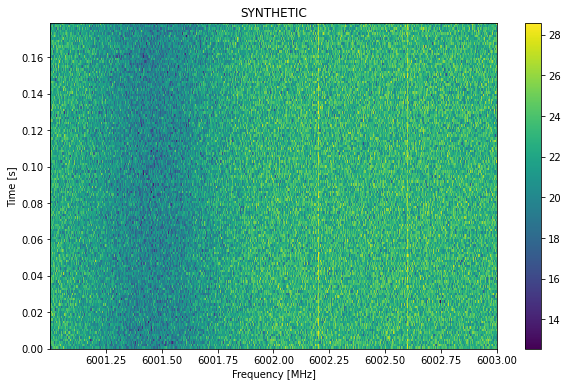

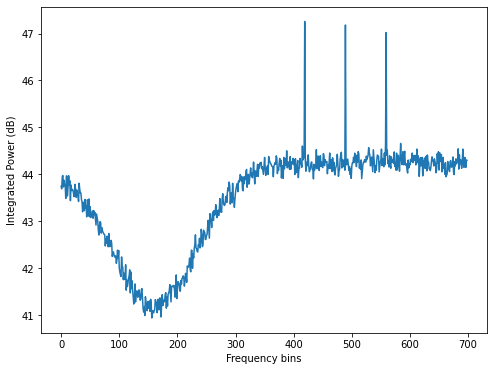

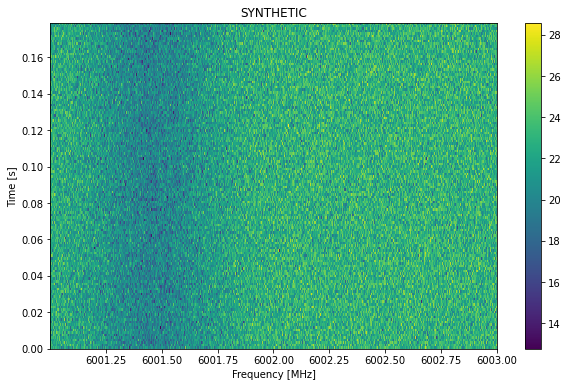

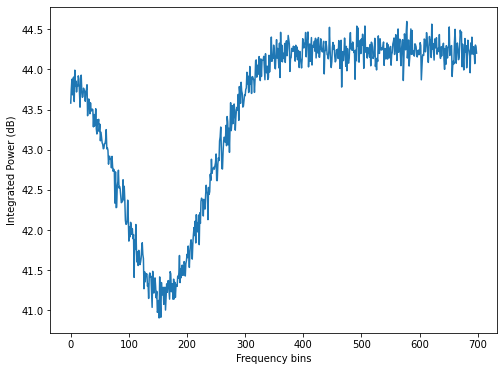

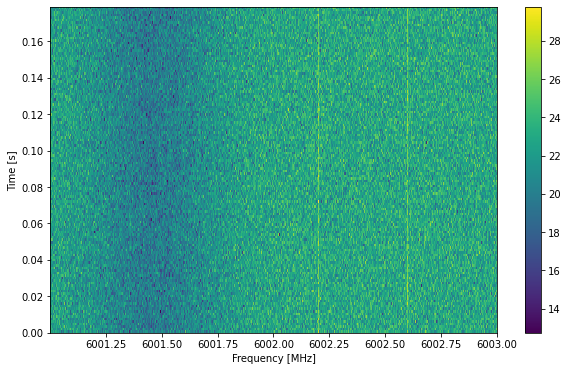

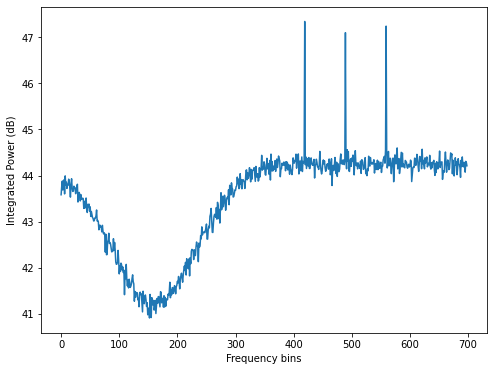

In [7]:
sample_rate = 3e9
num_taps = 8
num_branches = 1024

chan_bw = sample_rate / num_branches

antenna = stg.voltage.Antenna(sample_rate=sample_rate, 
                              fch1=6*u.GHz,
                              ascending=True,
                              num_pols=2)

for stream in antenna.streams:
    stream.add_noise(0, 1)
    stream.add_constant_signal(f_start=6002.2e6, 
                               drift_rate=-2,
                               level=0.002,
                               phase=0)
    stream.add_constant_signal(f_start=6002.4e6, 
                               drift_rate=-2,
                               level=0.002,
                               phase=0)
    stream.add_constant_signal(f_start=6002.6e6, 
                               drift_rate=-2,
                               level=0.002,
                               phase=0)
    
digitizer = stg.voltage.RealQuantizer(target_mean=0, 
                                      target_fwhm=32,
                                      num_bits=8)

filterbank = stg.voltage.PolyphaseFilterbank(num_taps=num_taps, 
                                             num_branches=num_branches)

requantizer = stg.voltage.ComplexQuantizer(target_mean=0,
                                           target_fwhm=32,
                                           num_bits=8)

rvb = stg.voltage.RawVoltageBackend(antenna,
                                    digitizer=digitizer,
                                    filterbank=filterbank,
                                    requantizer=requantizer,
                                    start_chan=0,
                                    num_chans=64,
                                    block_size=134217728,
                                    blocks_per_file=128,
                                    num_subblocks=32)

rvb.record(output_file_stem='example_1block_sig',
           num_blocks=1, 
           length_mode='num_blocks',
           header_dict={'HELLO': 'test_value',
                        'TELESCOP': 'GBT'},
           verbose=False)

!rawspec -f 1024 -t 4 example_1block_sig

#####################################

antenna = stg.voltage.Antenna(sample_rate=sample_rate, 
                              fch1=6*u.GHz,
                              ascending=True,
                              num_pols=2)

for stream in antenna.streams:
    stream.add_noise(0, 1)
#     stream.add_constant_signal(f_start=6002.2e6, 
#                                drift_rate=-2,
#                                level=0.002,
#                                phase=0)
    
digitizer = stg.voltage.RealQuantizer(target_mean=0, 
                                      target_fwhm=32,
                                      num_bits=8)

filterbank = stg.voltage.PolyphaseFilterbank(num_taps=num_taps, 
                                             num_branches=num_branches)

requantizer = stg.voltage.ComplexQuantizer(target_mean=0,
                                           target_fwhm=32,
                                           num_bits=8)

rvb = stg.voltage.RawVoltageBackend(antenna,
                                    digitizer=digitizer,
                                    filterbank=filterbank,
                                    requantizer=requantizer,
                                    start_chan=0,
                                    num_chans=64,
                                    block_size=134217728,
                                    blocks_per_file=128,
                                    num_subblocks=32)

rvb.record(output_file_stem='example_1block',
           num_blocks=1, 
           length_mode='num_blocks',
           header_dict={'HELLO': 'test_value',
                        'TELESCOP': 'GBT'},
           verbose=False)

!rawspec -f 1024 -t 4 example_1block

#####################################
sample_rate = 3e9
num_taps = 8
num_branches = 1024

input_file_stem = 'example_1block'

start_chan = 0

# currently this is 'populate_pipeline_elements' in read_raw.ipynb
raw_params = stg.voltage.get_raw_params(input_file_stem=input_file_stem,
                                        start_chan=start_chan)
# sample_rate and delays aren't actually used by the raw file... this is just for convenience


# antenna = stg.voltage.Antenna(sample_rate=raw_params['sample_rate'], 
#                               fch1=raw_params['fch1'],
#                               ascending=raw_params['ascending'],
#                               num_pols=raw_params['num_pols'])

"""or"""
# accept dict, create antenna automatically! just expand dict; added kwargs to antennas 
# to accept these parameters!
antenna = stg.voltage.Antenna(sample_rate=sample_rate,
                              **raw_params)

for stream in antenna.streams:
#     stream.add_noise(0, 1)
    stream.add_constant_signal(f_start=6002.2e6, 
                               drift_rate=-2,
                               level=0.002,
                               phase=0)
    stream.add_constant_signal(f_start=6002.4e6, 
                               drift_rate=-2,
                               level=0.002,
                               phase=0)
    stream.add_constant_signal(f_start=6002.6e6, 
                               drift_rate=-2,
                               level=0.002,
                               phase=0)

# maa = stg.voltage.MultiAntennaArray(sample_rate, 
#                                     **raw_params, 
#                                     delays=None)
    
digitizer = stg.voltage.RealQuantizer(target_mean=0, 
                                      target_fwhm=32,
                                      num_bits=8)

filterbank = stg.voltage.PolyphaseFilterbank(num_taps=num_taps, 
                                             num_branches=num_branches)

rvb = stg.voltage.RawVoltageBackend.from_data(input_file_stem=input_file_stem,
                                              antenna_source=antenna,
                                              digitizer=digitizer,
                                              filterbank=filterbank,
                                              start_chan=start_chan,
                                              num_subblocks=32)

rvb.record(output_file_stem='example_1block_input',
           num_blocks=1, 
           length_mode='num_blocks',
           header_dict={'HELLO': 'test_value',
                        'TELESCOP': 'GBT'},
           digitize=False,
           verbose=False)

# get_dists('example_1block_input.0000.raw')
!rawspec -f 1024 -t 4 example_1block_input

wf = bl.Waterfall('example_1block_sig.rawspec.0000.fil',
                  f_start=6001.0,
                  f_stop=6003)

plt.figure(figsize=(10, 6))
wf.plot_waterfall()
plt.show()

x = stg.db(np.sum(wf.data[:, 0, :], axis=0))

plt.figure(figsize=(8, 6))
plt.plot(x)
plt.xlabel('Frequency bins')
plt.ylabel('Integrated Power (dB)')
plt.show()

wf = bl.Waterfall('example_1block.rawspec.0000.fil',
                  f_start=6001.0,
                  f_stop=6003)

plt.figure(figsize=(10, 6))
wf.plot_waterfall()
plt.show()

x = stg.db(np.sum(wf.data[:, 0, :], axis=0))

plt.figure(figsize=(8, 6))
plt.plot(x)
plt.xlabel('Frequency bins')
plt.ylabel('Integrated Power (dB)')
plt.show()

wf = bl.Waterfall('example_1block_input.rawspec.0000.fil',
                  f_start=6001.0,
                  f_stop=6003)

plt.figure(figsize=(10, 6))
wf.plot_waterfall()
plt.show()

x = stg.db(np.sum(wf.data[:, 0, :], axis=0))

plt.figure(figsize=(8, 6))
plt.plot(x)
plt.xlabel('Frequency bins')
plt.ylabel('Integrated Power (dB)')
plt.show()

Blocks: 100%|██████████| 1/1 [00:07<00:00,  7.23s/it]     

working stem: example_snr
opening file: example_snr.0000.raw


opening file: example_snr.0001.raw [No such file or directory]
output product 0: 128 spectra


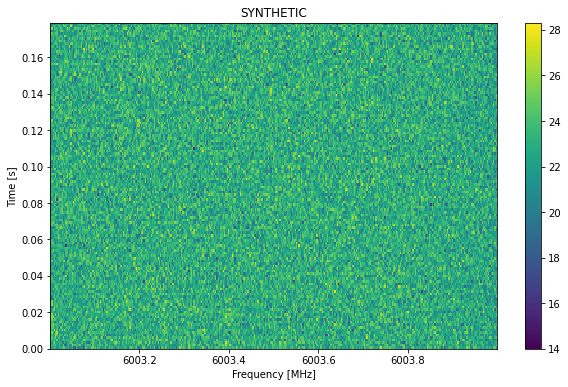

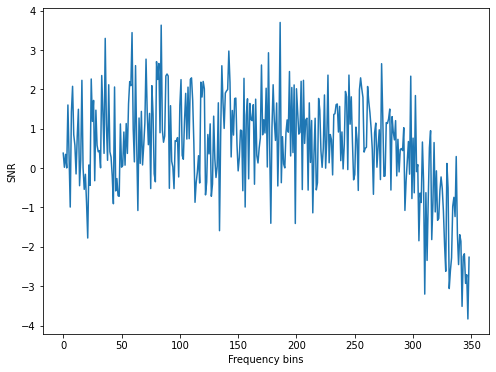

Blocks:   0%|          | 0/1 [00:00<?, ?it/s]

6003.1000 MHz leakage factor: 1.487
0.001623689982343338
0.001623689982343338
6003.2000 MHz leakage factor: 1.514
0.0016530230195459272
0.0016530230195459272
6003.3000 MHz leakage factor: 1.392
0.0015202416479446808
0.0015202416479446808
6003.4000 MHz leakage factor: 1.295
0.0014139799658038448
0.0014139799658038448
6003.5000 MHz leakage factor: 1.217
0.0013286981154369075
0.0013286981154369075
6003.6000 MHz leakage factor: 1.154
0.0012604306188112408
0.0012604306188112408
6003.7000 MHz leakage factor: 1.105
0.001206300539943633
0.001206300539943633
6003.8000 MHz leakage factor: 1.066
0.001164209193434652
0.001164209193434652
6003.9000 MHz leakage factor: 1.037
0.0011326335555582082
0.0011326335555582082



Blocks: 100%|██████████| 1/1 [00:24<00:00, 24.67s/it]     

working stem: example_snr_input
opening file: example_snr_input.0000.raw


opening file: example_snr_input.0001.raw [No such file or directory]
output product 0: 128 spectra


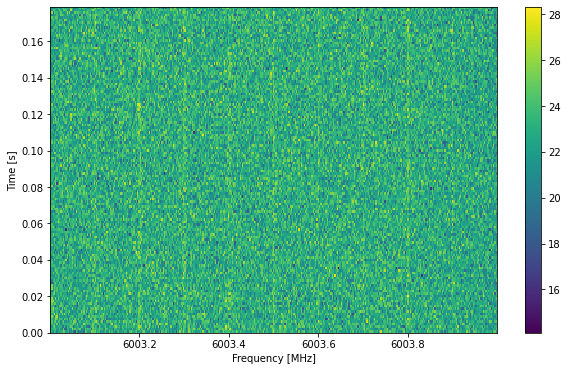

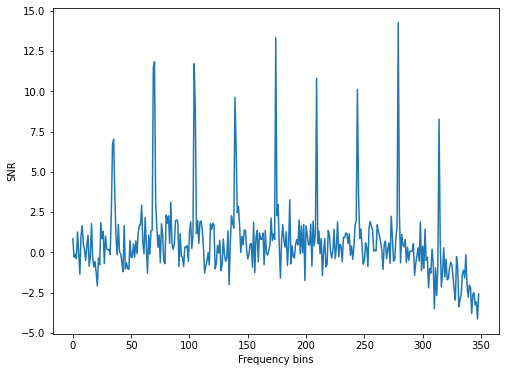

In [13]:
sample_rate = 3e9
num_taps = 8
num_branches = 1024

chan_bw = sample_rate / num_branches

digitizer = stg.voltage.RealQuantizer(target_fwhm=32,
                                      num_bits=8)

filterbank = stg.voltage.PolyphaseFilterbank(num_taps=num_taps, 
                                             num_branches=num_branches)

requantizer = stg.voltage.ComplexQuantizer(target_fwhm=32,
                                           num_bits=8)

antenna = stg.voltage.Antenna(sample_rate=sample_rate, 
                              fch1=6*u.GHz,
                              ascending=True,
                              num_pols=2)

rvb = stg.voltage.RawVoltageBackend(antenna,
                                    digitizer=digitizer,
                                    filterbank=filterbank,
                                    requantizer=requantizer,
                                    start_chan=0,
                                    num_chans=64,
                                    block_size=134217728,
                                    blocks_per_file=128,
                                    num_subblocks=32)

for stream in antenna.streams:
    stream.add_noise(v_mean=0, 
                     v_std=4)
    
fftlength = 1024
num_blocks = 1
        
rvb.record(output_file_stem='example_snr',
           num_blocks=num_blocks, 
           length_mode='num_blocks',
           header_dict={'HELLO': 'test_value',
                        'TELESCOP': 'GBT'},
           verbose=False)

!rawspec -f 1024 -t 4 -d . example_snr

wf = bl.Waterfall('example_snr.rawspec.0000.fil',
                  f_start=6003.0,
                  f_stop=6004.0)

plt.figure(figsize=(10, 6))
wf.plot_waterfall()
plt.show()

frame = stg.Frame(wf)

spectrum = stg.integrate_frame(frame, normalize=True)

plt.figure(figsize=(8, 6))
plt.plot(spectrum)
plt.xlabel('Frequency bins')
plt.ylabel('SNR')
plt.show()

#####################################
sample_rate = 3e9
num_taps = 8
num_branches = 1024

input_file_stem = 'example_snr'

start_chan = 0

# currently this is 'populate_pipeline_elements' in read_raw.ipynb
raw_params = stg.voltage.get_raw_params(input_file_stem=input_file_stem,
                                        start_chan=start_chan)

antenna = stg.voltage.Antenna(sample_rate=sample_rate,
                              **raw_params)


digitizer = stg.voltage.RealQuantizer(target_fwhm=32,
                                      num_bits=8)

filterbank = stg.voltage.PolyphaseFilterbank(num_taps=num_taps, 
                                             num_branches=num_branches)


rvb = stg.voltage.RawVoltageBackend.from_data(input_file_stem=input_file_stem,
                                              antenna_source=antenna,
                                              digitizer=digitizer,
                                              filterbank=filterbank,
                                              start_chan=start_chan,
                                              num_subblocks=32)




signal_level = stg.voltage.get_level(snr=10, 
                                     raw_voltage_backend=rvb,
                                     fftlength=fftlength,
                                     num_blocks=num_blocks,
                                     length_mode='num_blocks')
for f_start in np.linspace(6003.1e6, 6003.9e6, 9):
    leakage_factor = stg.voltage.get_leakage_factor(f_start, rvb, fftlength)
    print(f'{f_start/1e6:.4f} MHz leakage factor: {leakage_factor:.3f}')
    
    for stream in antenna.streams:
        level = 1 * leakage_factor * signal_level
#         level = stream.get_total_noise_std() * leakage_factor * signal_level
        print(level)
        stream.add_constant_signal(f_start=f_start, 
                                   drift_rate=0*u.Hz/u.s, 
                                   level=level)


rvb.record(output_file_stem='example_snr_input',
           num_blocks=1, 
           length_mode='num_blocks',
           header_dict={'HELLO': 'test_value',
                        'TELESCOP': 'GBT'},
           digitize=False,
           verbose=False)

!rawspec -f 1024 -t 4 -d . example_snr_input

wf = bl.Waterfall('example_snr_input.rawspec.0000.fil',
                  f_start=6003.0,
                  f_stop=6004.0)

plt.figure(figsize=(10, 6))
wf.plot_waterfall()
plt.show()

frame = stg.Frame(wf)

spectrum = stg.integrate_frame(frame, normalize=True)

plt.figure(figsize=(8, 6))
plt.plot(spectrum)
plt.xlabel('Frequency bins')
plt.ylabel('SNR')
plt.show()


working stem: /datax/scratch/bbrzycki/data/raw_files/blc00_guppi_59114_15868_TMC1_0010
opening file: /datax/scratch/bbrzycki/data/raw_files/blc00_guppi_59114_15868_TMC1_0010.0000.raw
opening file: /datax/scratch/bbrzycki/data/raw_files/blc00_guppi_59114_15868_TMC1_0010.0001.raw [No such file or directory]
output product 0: 16384 spectra


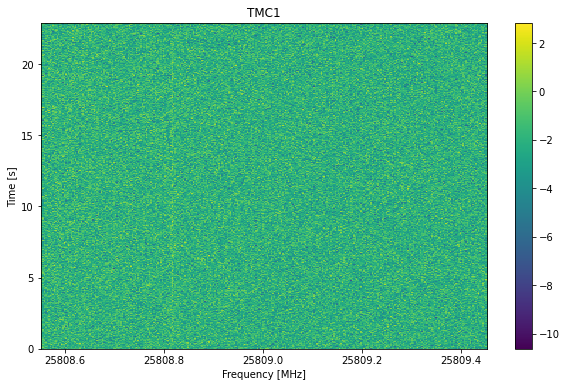

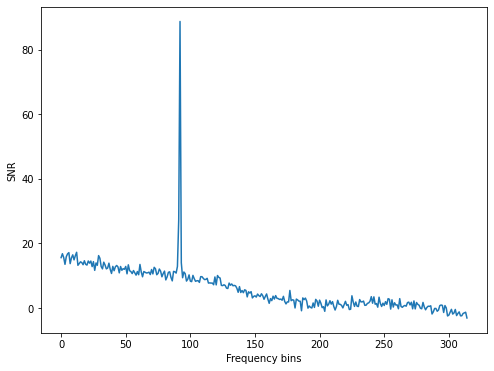

In [19]:
!rawspec -f 1024 -t 4 /datax/scratch/bbrzycki/data/raw_files/blc00_guppi_59114_15868_TMC1_0010

raw_params = stg.voltage.get_raw_params(input_file_stem='/datax/scratch/bbrzycki/data/raw_files/blc00_guppi_59114_15868_TMC1_0010',
                                        start_chan=0)

wf = bl.Waterfall('/datax/scratch/bbrzycki/data/raw_files/blc00_guppi_59114_15868_TMC1_0010.rawspec.0000.fil',
                  f_start=raw_params['fch1']/1e6-3.95,
                  f_stop=raw_params['fch1']/1e6-3.05)

plt.figure(figsize=(10, 6))
wf.plot_waterfall()
plt.show()

frame = stg.Frame(wf)

spectrum = stg.integrate_frame(frame, normalize=True)

plt.figure(figsize=(8, 6))
plt.plot(spectrum)
plt.xlabel('Frequency bins')
plt.ylabel('SNR')
plt.show()

working stem: /datax/scratch/bbrzycki/data/raw_files/blc00_guppi_59114_15868_TMC1_0010
opening file: /datax/scratch/bbrzycki/data/raw_files/blc00_guppi_59114_15868_TMC1_0010.0000.raw
opening file: /datax/scratch/bbrzycki/data/raw_files/blc00_guppi_59114_15868_TMC1_0010.0001.raw [No such file or directory]
output product 0: 16 spectra


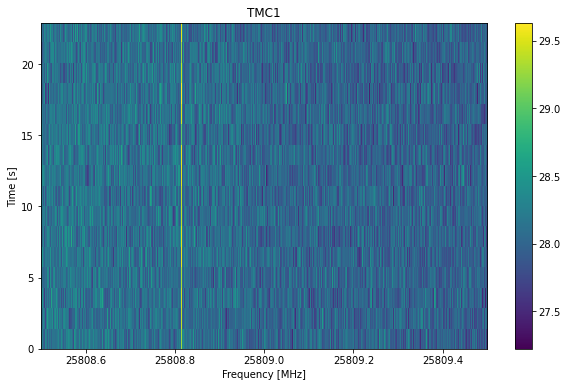

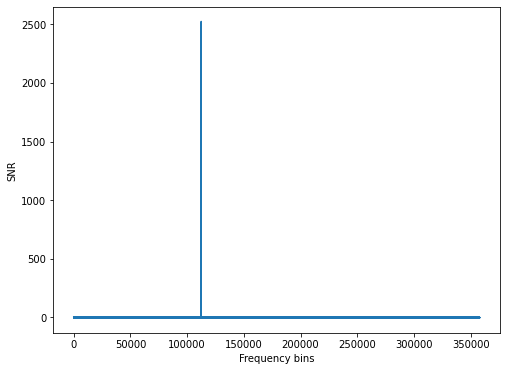

In [30]:
!rawspec -f 1048576 -t 4 /datax/scratch/bbrzycki/data/raw_files/blc00_guppi_59114_15868_TMC1_0010

raw_params = stg.voltage.get_raw_params(input_file_stem='/datax/scratch/bbrzycki/data/raw_files/blc00_guppi_59114_15868_TMC1_0010',
                                        start_chan=0)

wf = bl.Waterfall('/datax/scratch/bbrzycki/data/raw_files/blc00_guppi_59114_15868_TMC1_0010.rawspec.0000.fil',
                  f_start=raw_params['fch1']/1e6-4,
                  f_stop=raw_params['fch1']/1e6-3)

plt.figure(figsize=(10, 6))
wf.plot_waterfall()
plt.show()

frame = stg.Frame(wf)

spectrum = stg.integrate_frame(frame, normalize=True)

plt.figure(figsize=(8, 6))
plt.plot(spectrum)
plt.xlabel('Frequency bins')
plt.ylabel('SNR')
plt.show()

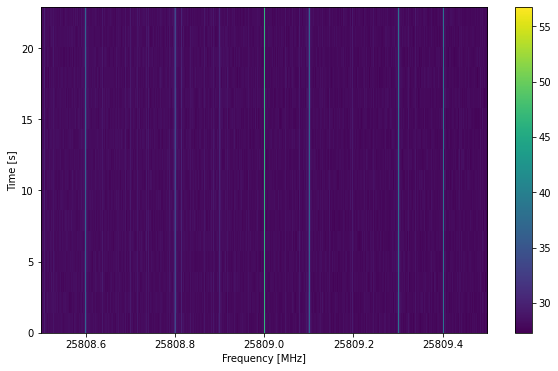

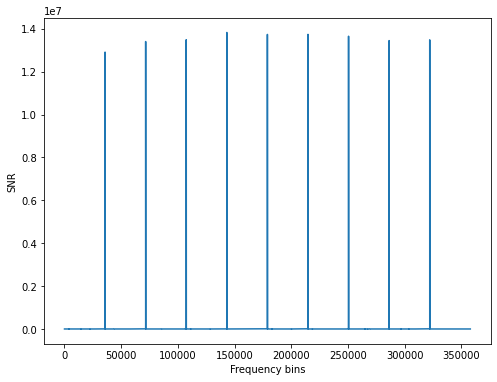

In [35]:
# !rawspec -f 1048576 -t 4 /datax/scratch/bbrzycki/data/raw_files/blc00_guppi_59114_15868_TMC1_0010_injected

raw_params = stg.voltage.get_raw_params(input_file_stem='/datax/scratch/bbrzycki/data/raw_files/blc00_guppi_59114_15868_TMC1_0010_injected',
                                        start_chan=0)

wf = bl.Waterfall('/datax/scratch/bbrzycki/data/raw_files/blc00_guppi_59114_15868_TMC1_0010_injected.rawspec.0000.fil',
                  f_start=raw_params['fch1']/1e6-4,
                  f_stop=raw_params['fch1']/1e6-3)

plt.figure(figsize=(10, 6))
wf.plot_waterfall()
plt.show()

frame = stg.Frame(wf)

spectrum = stg.integrate_frame(frame, normalize=True)

plt.figure(figsize=(8, 6))
plt.plot((spectrum))
plt.xlabel('Frequency bins')
plt.ylabel('SNR')
plt.show()

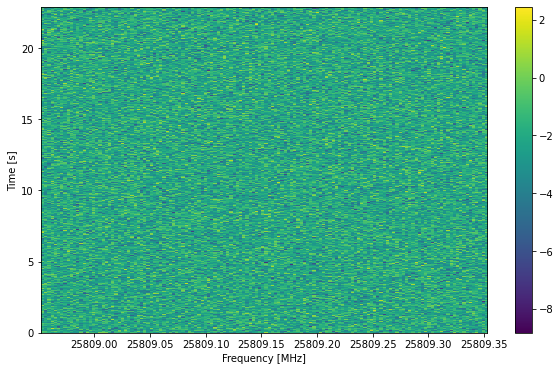

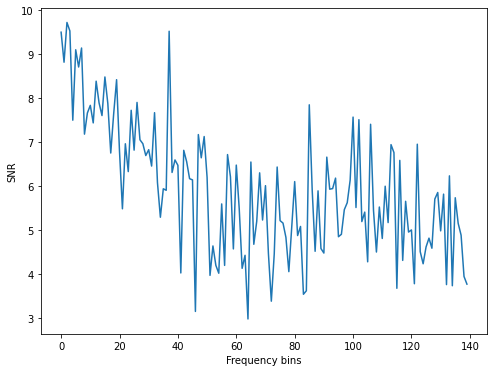

In [24]:
wf = bl.Waterfall('/datax/scratch/bbrzycki/data/raw_files/blc00_guppi_59114_15868_TMC1_0010_injected.rawspec.0000.fil',
                  f_start=raw_params['fch1']/1e6-3.55,
                  f_stop=raw_params['fch1']/1e6-3.15)

plt.figure(figsize=(10, 6))
wf.plot_waterfall()
plt.show()

frame = stg.Frame(wf)

spectrum = stg.integrate_frame(frame, normalize=True)

plt.figure(figsize=(8, 6))
plt.plot(spectrum)
plt.xlabel('Frequency bins')
plt.ylabel('SNR')
plt.show()

In [10]:
frequencies = raw_params['fch1'] + (raw_params['ascending'] * 2 - 1) * np.linspace(3.1e6, 3.9e6, 9)
frequencies / 1e6

array([25809.4, 25809.3, 25809.2, 25809.1, 25809. , 25808.9, 25808.8,
       25808.7, 25808.6])